In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d soumikrakshit/anime-faces

Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/anime-faces
License(s): unknown
100% 440M/441M [00:21<00:00, 23.3MB/s]
100% 441M/441M [00:21<00:00, 21.2MB/s]


In [ ]:
from zipfile import ZipFile
dataset = '/content/anime-faces.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
!pip install tensorflow

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

In [ ]:
BASE_DIR='/content/data'

In [ ]:
image_paths = []
for image_name in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, image_name)
    image_paths.append(image_path)

In [ ]:
image_paths[:5]

['/content/data/17983.png',
 '/content/data/4579.png',
 '/content/data/7381.png',
 '/content/data/9898.png',
 '/content/data/3752.png']

In [ ]:
len(image_paths)

21552

In [ ]:
image_paths.remove('/content/data/data')

In [ ]:
len(image_paths)

21551

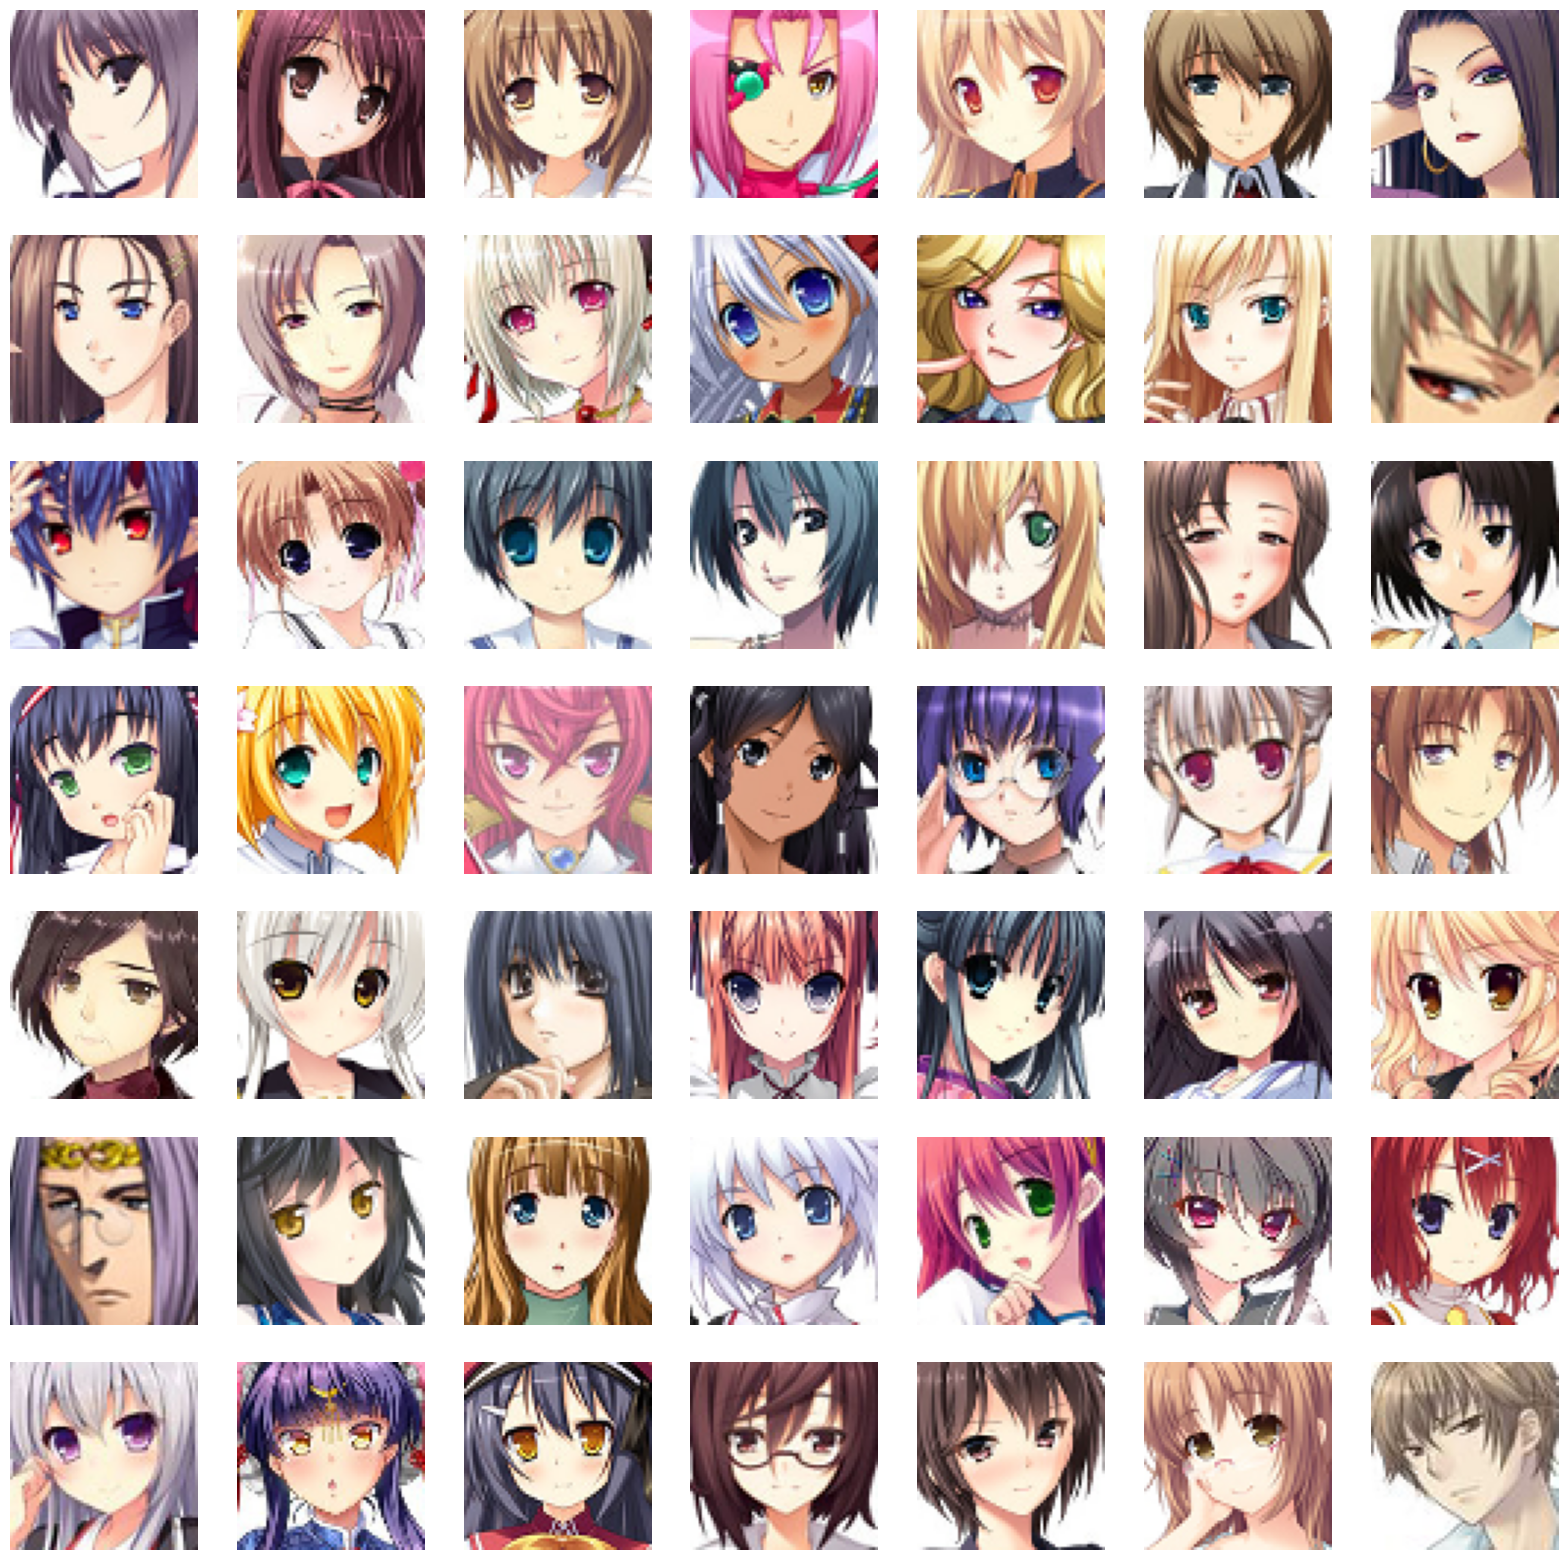

In [ ]:
plt.figure(figsize=(20, 20))
temp_images = image_paths[:49]
index = 1

for image_path in temp_images:
    plt.subplot(7, 7, index)
    # load the image
    img = load_img(image_path)
    # convert to numpy array
    img = np.array(img)
    # show the image
    plt.imshow(img)
    plt.axis('off')
    # increment the index for next image
    index += 1

In [ ]:
train_images = [np.array(load_img(path)) for path in tqdm(image_paths)]
train_images = np.array(train_images)

  0%|          | 0/21551 [00:00<?, ?it/s]

In [ ]:
train_images[0].shape

(64, 64, 3)

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32')


In [ ]:
train_images = (train_images - 127.5) / 127.5

In [ ]:
train_images[0]

array([[[ 0.9607843 ,  1.        ,  0.99215686],
        [ 1.        ,  1.        ,  1.        ],
        [ 0.3254902 ,  0.21568628,  0.31764707],
        ...,
        [ 0.09019608, -0.10588235,  0.06666667],
        [-0.08235294, -0.27058825, -0.09019608],
        [-0.03529412, -0.22352941, -0.03529412]],

       [[ 0.9843137 ,  1.        ,  1.        ],
        [ 1.        ,  0.94509804,  1.        ],
        [-0.11372549, -0.29411766, -0.13725491],
        ...,
        [ 0.05098039, -0.13725491,  0.05098039],
        [-0.06666667, -0.24705882, -0.06666667],
        [ 0.05098039, -0.12156863,  0.05882353]],

       [[ 1.        ,  1.        ,  1.        ],
        [ 0.654902  ,  0.6       ,  0.654902  ],
        [-0.18431373, -0.35686275, -0.20784314],
        ...,
        [ 0.01176471, -0.1764706 ,  0.01176471],
        [-0.04313726, -0.23137255, -0.04313726],
        [-0.01960784, -0.20784314, -0.01960784]],

       ...,

       [[ 1.        ,  1.        ,  1.        ],
        [ 1

In [ ]:
LATENT_DIM = 100
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
CHANNELS = 3 # for gray scale, keep it as 1

In [ ]:
model = Sequential(name='generator')


model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
model.add(layers.ReLU())


model.add(layers.Reshape((8, 8, 512)))


model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())


model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())


model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32768)               │       3,309,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,065,603 (23.14 MB)

 Trainable params: 6,065,603 (23.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = Sequential(name='discriminator')
input_shape = (64, 64, 3)
alpha = 0.2


model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))


model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 406,081 (1.55 MB)

 Trainable params: 405,441 (1.55 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]

        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))


        with tf.GradientTape() as tape:

            pred_real = self.discriminator(real_images, training=True)

            real_labels = tf.ones((batch_size, 1))

            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)


            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)

            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)


            d_loss = (d_loss_real + d_loss_fake) / 2


        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)

        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))



        labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:

            fake_images = self.generator(random_noise, training=True)

            pred_fake = self.discriminator(fake_images, training=True)

            g_loss = self.loss_fn(labels, pred_fake)


        gradients = tape.gradient(g_loss, self.generator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))


        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [ ]:
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim

        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):

        g_img = self.model.generator(self.noise)

        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()

        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = array_to_img(g_img[i])
            plt.imshow(img)
            plt.axis('off')

        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [ ]:
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim

        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):

        g_img = self.model.generator(self.noise)

        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()

        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = array_to_img(g_img[i])
            plt.imshow(img)
            plt.axis('off')
        plt.show()


        return logs if logs is not None else {}

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

        return logs if logs is not None else {}

In [ ]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [ ]:
D_LR = 0.0001
G_LR = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())


In [ ]:
# Before running your code, check if 'zip' is a built-in function
import builtins
if not isinstance(builtins.zip, type(zip)):
    # If 'zip' is not the built-in function, restore it
    zip = builtins.zip
    print("Warning: 'zip' was overwritten. Restored to built-in function.")

In [ ]:
N_EPOCHS = 50
dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])


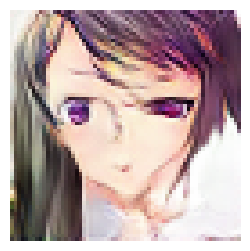

In [ ]:
noise = tf.random.normal([1, 100])
fig = plt.figure(figsize=(3, 3))
g_img = dcgan.generator(noise)
g_img = (g_img * 127.5) + 127.5
g_img.numpy()
img = array_to_img(g_img[0])
plt.imshow(img)
plt.axis('off')
plt.show()